In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

# header = {"mainGrid", "otherGrids", "hourOfDay"}
# three year power supply records from 1995 to 1998
def dataPreprocesssing():
    df = pd.read_csv('powerSupplyStream.csv')

    # create timestamps
    start = datetime.datetime(1995, 1, 1, 0)
    timestamp_list = [start + datetime.timedelta(hours=x) for x in range(len(df))]
    df['timestamps'] = timestamp_list

    # mistake in hours numbering hour 6 = 1248 instances
    #                                 9 = 1246 instances
    #wrongHoursIndex = [24969]
    #for i in np.arange(len(df)-1):
    #    if df['hourOfDay'][i]+1 != df['hourOfDay'][i + 1] and df['hourOfDay'][i] != 23:
    #        print("wtf")
   # df.at[wrongHoursIndex, 'hourOfDay'] = 9

    df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
    # hourly change in consumption
    diffMain = np.append(np.array(df_train['mainGrid']), 0) - np.append(0,np.array(df_train['mainGrid']))
    diffMain = diffMain[0:-1]
    diffMain[0] = 0
    diffOthers = np.append(np.array(df_train['otherGrids']), 0) - np.append(0,np.array(df_train['otherGrids']))
    diffOthers = diffOthers[0:-1]
    diffOthers[0] = 0

    df_train['diffMain'] = diffMain
    df_train['diffOthers'] = diffOthers

    df_hourDiffMain = pd.DataFrame()
    df_hourDiffOther = pd.DataFrame()

    return df_train, df_test

train_data, test_data =dataPreprocesssing()
train_data = train_data['mainGrid']
test_data = test_data['mainGrid']
num_train = train_data.size
num_test = test_data.size

In [3]:
def create_dataset(data, look_back):
  n = data.shape[0]
  x = np.zeros((n - look_back - 1, look_back))
  y = np.zeros(n - look_back - 1)
  for i in range(look_back):
    x[:, i] = data[i:n-look_back+i-1]

  y[:] = data[look_back:n - 1]

  return x, y

In [17]:
from torch.nn.modules import activation
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input
from keras.regularizers import l2, l1
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

look_back = 3
x_train, y_train = create_dataset(train_data.to_numpy(), look_back)
x_test, y_test = create_dataset(test_data.to_numpy(), look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# create LSTM
lstm_nunits = 32
d1_nunits = 32
d2_nunits = 16
out_nunits = 1
lstm_model = Sequential()
lstm_model.add(LSTM(lstm_nunits, input_shape=(1, look_back)))
lstm_model.add(Dense(d1_nunits, activation='relu'))
lstm_model.add(Dense(d2_nunits, activation='relu'))
lstm_model.add(Dense(out_nunits))
# to not create its own weights
for layer in lstm_model.layers:
    layer.built = True
lstm_model.summary()

lstm_nweights = 4608
d1_nweights = 1056
d2_nweights = 528
out_nweights = 17
nweights_to_generate = 6209


hypernet = Sequential()
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(nweights_to_generate,))



# Loss and optimizer.
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Prepare a dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# We'll use a batch size of 1 for this experiment.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)



def get_parameters(weights_pred):

  # Layer 0
  start_index = 0
  # kernel
  kernel0_shape = (3, 128)
  kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(kernel0_shape)]
  kernel0 = tf.reshape(kernel0_coeff, kernel0_shape)
  start_index += np.prod(kernel0_shape)
  # recurrent kernel
  recurrent_kernel0_shape = (3, 128)
  recurrent_kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(recurrent_kernel0_shape)]
  recurrent_kernel0 = tf.reshape(recurrent_kernel0_coeff, recurrent_kernel0_shape)
  start_index += np.prod(recurrent_kernel0_shape)
  # bias
  b0_shape = (128,)
  b0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b0_shape)]
  b0 = tf.reshape(b0_coeff, b0_shape)
  start_index += np.prod(b0_shape)

  #Layer 1
  # weights
  w1_shape = (32, 32)
  w1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w1_shape)]
  w1 = tf.reshape(w1_coeff, w1_shape)
  start_index += np.prod(w1_shape)
  # bias
  b1_shape = (32,)
  b1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b1_shape)]
  b1 = tf.reshape(b1_coeff, b1_shape)
  start_index += np.prod(b1_shape)

  #Layer 2
  # weights
  w2_shape = (32, 16)
  w2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w2_shape)]
  w2 = tf.reshape(w2_coeff, w2_shape)
  start_index += np.prod(w2_shape)
  # bias
  b2_shape = (16,)
  b2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b2_shape)]
  b2 = tf.reshape(b2_coeff, b2_shape)
  start_index += np.prod(b2_shape)

  #Layer 3
  # weights
  w3_shape = (16, 1)
  w3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w3_shape)]
  w3 = tf.reshape(w3_coeff, w3_shape)
  start_index += np.prod(w3_shape)
  # bias
  b3_shape = (1,)
  b3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b3_shape)]
  b3 = tf.reshape(b3_coeff, b3_shape)
  start_index += np.prod(b3_shape)
  

  return kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = hypernet(x)

        kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3 = get_parameters(weights_pred)

        # Set the weight predictions as the weight variables on the outer model.
        lstm_model.layers[0].kernel = kernel0
        lstm_model.layers[0].recurrent_kernel = recurrent_kernel0
        lstm_model.layers[0].bias = b0
        lstm_model.layers[1].kernel = w1
        lstm_model.layers[1].bias = b1
        lstm_model.layers[2].kernel = w2
        lstm_model.layers[2].bias = b2
        lstm_model.layers[3].kernel = w3
        lstm_model.layers[3].bias = b3

        # Inference on the outer model.
        preds = lstm_model(x)
        loss = loss_fn(y, preds)

    # Train only inner model.
    grads = tape.gradient(loss, hypernet.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernet.trainable_weights))
    return loss

from tqdm.notebook import trange, tqdm

for epoch in range(20):
  print("========================================================")
  print("Epoch ", epoch + 1)
  losses = []  # Keep track of the losses over time.
  for step, (x, y) in enumerate(tqdm(train_dataset, desc='Training')):
      loss = train_step(x, y)
      losses.append(float(loss))
  

  print("Loss ", np.sum(np.array(losses))/len(losses))

      

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4608      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________
Epoch  1


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  3030.7603379892603
Epoch  2


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  173.51345555858387
Epoch  3


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  163.7733699929209
Epoch  4


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  158.50313297727305
Epoch  5


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  155.19785702218482
Epoch  6


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  152.0387753237613
Epoch  7


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  150.8199672794089
Epoch  8


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  149.30972768933535
Epoch  9


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  147.30088476149731
Epoch  10


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  146.59679866998357
Epoch  11


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  146.27041579773692
Epoch  12


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  146.16482587420793
Epoch  13


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  144.95990264839656
Epoch  14


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  144.7517785757613
Epoch  15


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  143.7338429124163
Epoch  16


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  144.1056117749368
Epoch  17


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  143.0696590172536
Epoch  18


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  143.35151724865648
Epoch  19


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  143.06690842648212
Epoch  20


Training:   0%|          | 0/23938 [00:00<?, ?it/s]

Loss  142.27602814673048


In [18]:
#hypernet.save('hypernet1')

In [20]:
#!zip -r hypernet.zip hypernet

  adding: hypernet/ (stored 0%)
  adding: hypernet/keras_metadata.pb (deflated 88%)
  adding: hypernet/saved_model.pb (deflated 90%)
  adding: hypernet/assets/ (stored 0%)
  adding: hypernet/variables/ (stored 0%)
  adding: hypernet/variables/variables.index (deflated 46%)
  adding: hypernet/variables/variables.data-00000-of-00001 (deflated 10%)


Testing:   0%|          | 0/5982 [00:00<?, ?it/s]

Test set: MSE  182.421188819304  MAE  9.475821081510318


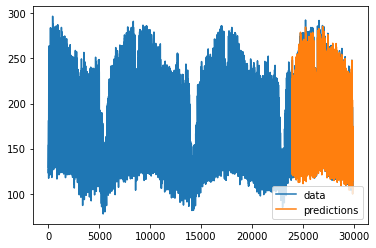

In [19]:
loss_fn1 = tf.keras.losses.MeanSquaredError()
loss_fn2 = tf.keras.losses.MeanAbsoluteError()

def predict_sample(x, y):
  with tf.GradientTape() as tape:
    weights_pred = hypernet(x)

    kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3 = get_parameters(weights_pred)

    # Set the weight predictions as the weight variables on the outer model.
    lstm_model.layers[0].kernel = kernel0
    lstm_model.layers[0].recurrent_kernel = recurrent_kernel0
    lstm_model.layers[0].bias = b0
    lstm_model.layers[1].kernel = w1
    lstm_model.layers[1].bias = b1
    lstm_model.layers[2].kernel = w2
    lstm_model.layers[2].bias = b2
    lstm_model.layers[3].kernel = w3
    lstm_model.layers[3].bias = b3

    # Inference on the outer model.
    preds = lstm_model(x)
    loss1 = loss_fn1(y, preds)
    loss2 = loss_fn2(y, preds)
  

  return preds, loss1, loss2


def evaluate_and_predict(dataset):
  losses1 = []
  losses2 = []
  predictions = []  
  for step, (x, y) in enumerate(tqdm(dataset, desc='Testing')):
      pred, loss1, loss2 = predict_sample(x, y)
      losses1.append(float(loss1))
      losses2.append(float(loss2))
      predictions.append(float(pred))

  return np.array(predictions), np.sum(np.array(losses1))/len(losses1), np.sum(np.array(losses2))/len(losses2)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(1)


pred_test, test_loss1, test_loss2 = evaluate_and_predict(test_dataset)
print("Test set: MSE ", test_loss1, " MAE ", test_loss2)

y = np.concatenate((y_train, y_test))
s = y.size
x = range(s)
plt.plot(x, y, label='data')
x1 = range(s - pred_test.size, s)
plt.plot(x1, pred_test, label='predictions')
plt.legend()
plt.show()